In [1]:
import gym
import numpy as np
from collections import defaultdict
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

In [2]:
FIGSIZE = 8, 6

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# Часть первая: крестики-нолики при помощи Q-обучения

In [4]:
class Agent:
    def __init__(self):
        self.state = None
        self.action = None
        
    def update_Q(self, Q, state, action, reward, alpha, gamma):
        Q[self.state][self.action] += alpha * (reward + gamma * np.max(Q[state]) - Q[self.state][self.action])
        self.state = state
        self.action = action
    
    
class CrossesAgent(Agent):
    pass


class NoughtsAgent(Agent):
    pass

In [5]:
class Qlearner:
    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.Q = defaultdict(lambda: np.zeros(n_rows * n_cols))
    
    @staticmethod
    def _get_available_actions(state):
        return np.where(np.array(list(state)) == '1')[0]
    
    def play(self, crosses_random=False, noughts_random=False):
        self.env.reset()
        state, _, _ = self.env.getState()
        done = False
        crosses_turn = True
        crosses_reward = 0
        noughts_reward = 0
        while not done:
            if (crosses_turn and crosses_random) or (not crosses_turn and noughts_random):
                action = np.random.choice(self._get_available_actions(state))
            else:
                action = np.argmax(self.Q[state])
            (state, empty_spaces, turn), reward, done, _ = self.env.step(self.env.action_from_int(action))
            crosses_turn = not crosses_turn
        if reward == 1:
            crosses_reward = 1
        elif reward == -1:
            noughts_reward = 1
        return crosses_reward, noughts_reward
    
    def evaluate(self, num_games=1000, **game_kwargs):
        crosses_rewards = []
        noughts_rewards = []
        for _ in range(num_games):
            crosses_reward, noughts_reward = self.play(**game_kwargs)
            crosses_rewards.append(crosses_reward)
            noughts_rewards.append(noughts_reward)
        return np.mean(crosses_rewards), np.mean(noughts_rewards)
    
    def update_Q_unavailable_actions(self, state):
        unavailable_actions = np.where(np.array(list(state)) != '1')[0]
        self.Q[state][unavailable_actions] = -np.inf
        
    def Q_learning_episode(self, epsilon, alpha, gamma):
        self.env.reset()
        state, _, _ = self.env.getState()    
        done = False
        crosses_agent = CrossesAgent()
        noughts_agent = NoughtsAgent()
        crosses_turn = True
        reward = 0
        while not done:
            agent = crosses_agent if crosses_turn else noughts_agent
            self.update_Q_unavailable_actions(state)
            if np.random.random() < epsilon:
                action = np.random.choice(self._get_available_actions(state))
            else:
                action = np.argmax(self.Q[state])
            agent.update_Q(self.Q, state, action, reward, alpha, gamma)
            (state, _, _), reward, done, _ = self.env.step(self.env.action_from_int(action))
            crosses_turn = not crosses_turn
        if reward == -10:
            agent.update_Q(self.Q, state, action, reward, alpha, gamma)
        else:
            crosses_agent.update_Q(self.Q, state, action, reward, alpha, gamma) 
            noughts_agent.update_Q(self.Q, state, action, -reward, alpha, gamma) 

    def plot_results(self, iterations, history, title):
        plt.figure(figsize=FIGSIZE)
        sns.lineplot(x=iterations, y=history)
        plt.title(f"{title}, {self.n_rows}x{self.n_cols}")
        plt.xlabel("Number of Episodes")
        plt.ylabel("Share of Wins")
        plt.show()
    
    def learn_Q(self, num_episodes=100000, epsilon=0.5, alpha=0.01, gamma=0.99, evaluate_period=100):
        crosses_history = []
        noughts_history = []
        iterations = []
        for i in trange(num_episodes):
            self.Q_learning_episode(epsilon, alpha, gamma)
            if i % evaluate_period == 0:
                crosses_res = self.evaluate(crosses_random=False, noughts_random=True)[0]
                noughts_res = self.evaluate(crosses_random=True, noughts_random=False)[1]
                crosses_history.append(crosses_res)
                noughts_history.append(noughts_res)
                iterations.append(i)
        self.plot_results(iterations, crosses_history, "Crosses against random Noughts")
        self.plot_results(iterations, noughts_history, "Noughts against random Crosses")

## 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

  0%|          | 0/100000 [00:00<?, ?it/s]

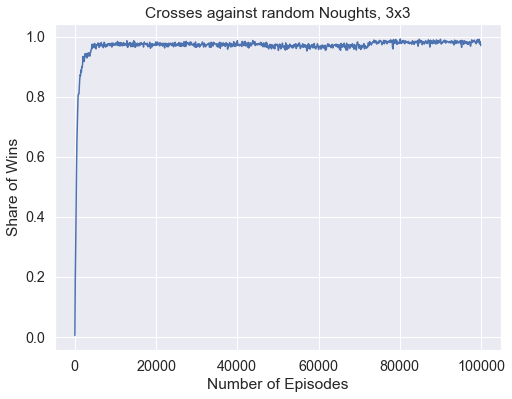

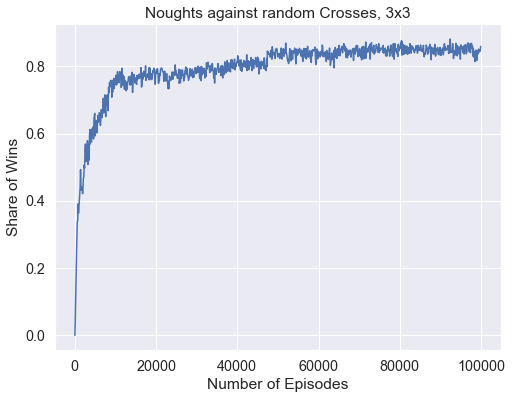

In [6]:
qlearner_3x3 = Qlearner(3, 3, 3)
qlearner_3x3.learn_Q(num_episodes=100000)

## 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

  0%|          | 0/1000000 [00:00<?, ?it/s]

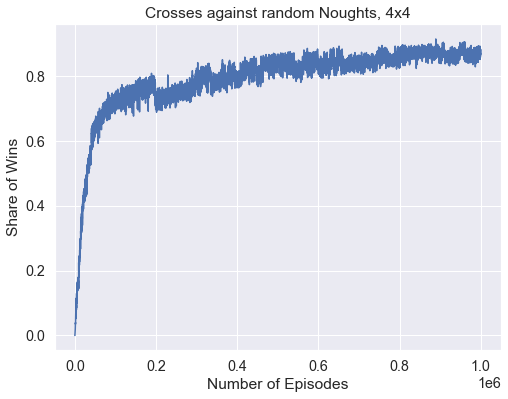

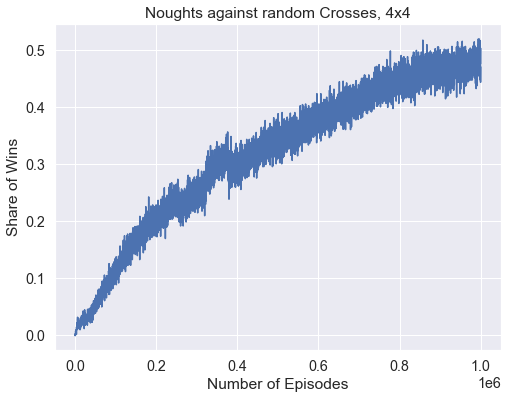

In [7]:
qlearner_4x4 = Qlearner(4, 4, 4)
qlearner_4x4.learn_Q(num_episodes=1000000)